In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
import os
import warnings
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

from quantnn.models.pytorch.common import QuantileLoss

from convert_np import ComputeStatsFromNumpyFiles, ConvertDatasetToNumpy
from load_data import GOESRETRIEVALSDataset, Mask, Standardize, ToTensor
from models.FirstGenericNet import Net
from visualize.sample_plots import plotRandomSample


cuda


In [2]:
'''
def mask(output, y, fillval = -1):
    m = (y==fillval)
    m_rep = m.unsqueeze(1).repeat(1,output.shape[1], 1, 1)
    
    output[torch.where(m_rep)] = fillval
    
    return(output)
'''  

def train(model, X, y, optimizer, criterion):
    optimizer.zero_grad()
    
    output = model(X)
    #output = mask(output, y)
    
    loss = criterion(output, y.unsqueeze(1))
    loss.backward()
    
    optimizer.step()

    return loss


[[232.412775   266.9276385 ]
 [  7.6032952   21.61798888]]
[[232.412775   266.9276385 ]
 [  7.6032952   21.61798888]]


64

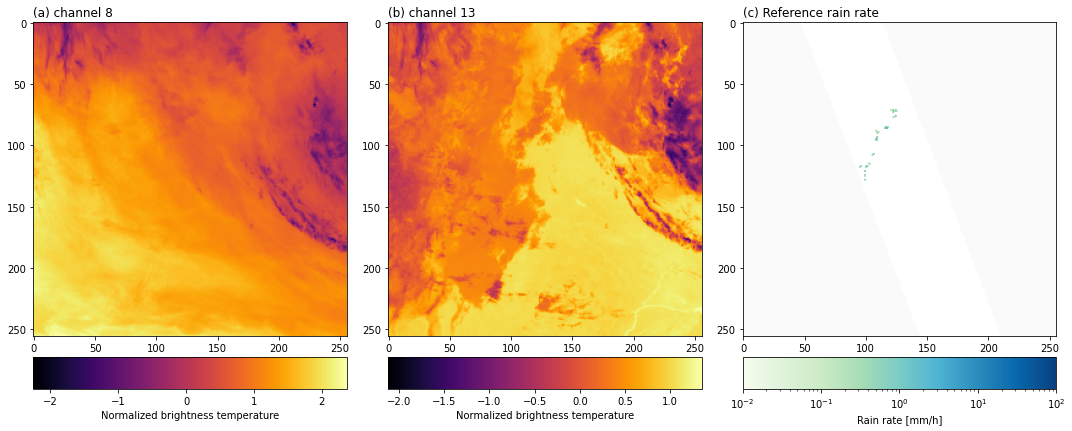

In [3]:
# SETUP
channels = [8, 13]
fillvalue = -1

EPOCHS = 10
BATCH_SIZE = 2

quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

# TRAIN DATA
path_to_load_train_data = '/home/ingrid/Dendrite/UserAreas/Ingrid/Dataset/linkfile2017-12/'#'data/first_net_dataset/train/'
path_to_save_train_data = 'data/first_net_dataset/train/npy_files'
path_to_stats = os.path.join(Path(path_to_save_train_data).parent, Path('stats.npy'))
path_to_state_dict = 'models/saved_models/FirstGenericNet_state_dict.pt'

ConvertDatasetToNumpy(path_to_load_data=path_to_load_train_data,
                      path_to_save_data=path_to_save_train_data)

train_dataset = GOESRETRIEVALSDataset(
    path_to_data=path_to_save_train_data,
    channels=channels, 
    transform=transforms.Compose([Mask(), 
                                    Standardize(path_to_save_train_data, path_to_stats, channels),
                                    ToTensor()])
)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# VALIDATION DATA
path_to_load_val_data = '/home/ingrid/Dendrite/UserAreas/Ingrid/Dataset/linkfile2018-01/'
path_to_save_val_data = 'data/first_net_dataset/validation/npy_files'

ConvertDatasetToNumpy(path_to_load_data = path_to_load_val_data,
                      path_to_save_data = path_to_save_val_data)

val_dataset = GOESRETRIEVALSDataset(
    path_to_data = path_to_save_val_data,
    channels = channels, 
    transform = transforms.Compose([Mask(),
                                    Standardize(path_to_save_val_data, path_to_stats, channels),
                                    ToTensor()])
)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# PLOT DATA
plotRandomSample(train_dataset)

In [4]:
net = Net(len(quantiles), len(channels), 1)
net.to(device)

criterion = QuantileLoss(quantiles=quantiles, mask=fillvalue)
criterion.to(device=device)
optimizer = SGD(net.parameters(), lr = 0.1)

writer = SummaryWriter()

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_index, batch in enumerate(train_dataloader):
        X = batch['box'].to(device)
        y = batch['label'].to(device)

        batch_loss = train(net, X, y, optimizer, criterion)
        #print('batch_loss', batch_loss.item())
        epoch_loss += batch_loss.item()
    
    writer.add_scalar('Loss/train', epoch_loss/(batch_index+1), epoch)
    print('epoch', epoch, 'average train loss: ', epoch_loss/(batch_index+1))
    
    tot_val_loss = 0
    
    with torch.no_grad():
        for batch_index, batch in enumerate(val_dataloader):

            X = batch['box'].to(device).detach()
            y = batch['label'].to(device).detach()

            output = net(X)
            #output = mask(output, y)

            batch_loss_val = criterion(output, y.unsqueeze(1))

            tot_val_loss += batch_loss_val.item()

        print('epoch', epoch, 'average validation loss: ', tot_val_loss/(batch_index+1))

epoch 0 average train loss:  0.14427409756858395
epoch 0 average validation loss:  0.09847141222642927
epoch 1 average train loss:  0.12637787625053018
epoch 1 average validation loss:  0.09463077718552587
epoch 2 average train loss:  0.12268645731064509
epoch 2 average validation loss:  0.0900744810331099
epoch 3 average train loss:  0.11953489821544795
epoch 3 average validation loss:  0.08923821514954083
epoch 4 average train loss:  0.1182223292911109
epoch 4 average validation loss:  0.08875178747232361
epoch 5 average train loss:  0.11648092691276996
epoch 5 average validation loss:  0.0896908307191113
epoch 6 average train loss:  0.11652640509858446
epoch 6 average validation loss:  0.08846474176369093
epoch 7 average train loss:  0.11591656073787303
epoch 7 average validation loss:  0.08758680901393809
epoch 8 average train loss:  0.11732134915326002
epoch 8 average validation loss:  0.08719618420983696
epoch 9 average train loss:  0.11581811175312635
epoch 9 average validation 

In [5]:
#torch.save(net.state_dict(), path_to_state_dict)

[[-1.09041199e-01 -1.09116271e-01 -1.06356174e-01 ...  2.86369771e-03
  -6.87979162e-03 -1.26447529e-04]
 [-1.12741381e-01 -1.12750307e-01 -1.12497881e-01 ...  1.03196073e-02
   3.06746792e-02  3.73009220e-02]
 [-1.11154616e-01 -1.12302482e-01 -1.12525880e-01 ...  1.22363772e-02
   3.39032561e-02  7.81298280e-02]
 ...
 [ 1.58024356e-01  1.54158905e-01  9.64433700e-02 ...  1.53534617e-02
  -1.30834356e-02  1.60629507e-02]
 [ 1.94878489e-01  1.82103023e-01  9.47319418e-02 ...  2.68528983e-03
  -3.84482481e-02 -4.48908247e-02]
 [ 1.86859474e-01  3.23254824e-01  1.81714058e-01 ... -2.27572508e-02
  -3.86459567e-02 -6.38509989e-02]]


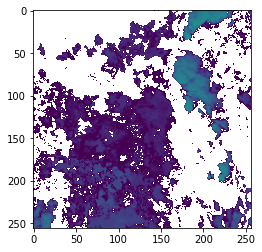

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
precip_norm = LogNorm(1e-2, 1e2)
plt.imshow(torch.squeeze(net(val_dataset[100]['box'].unsqueeze(0).to(device))[:,6]).detach().cpu().numpy(), norm=precip_norm)
print(torch.squeeze(net(val_dataset[100]['box'].unsqueeze(0).to(device))[:,6]).detach().cpu().numpy())

In [7]:
#Test load data:
#net = Net(len(quantiles), len(channels), 1)
#net.load_state_dict(torch.load(path_to_state_dict))
#net.eval()

0.5
index  75


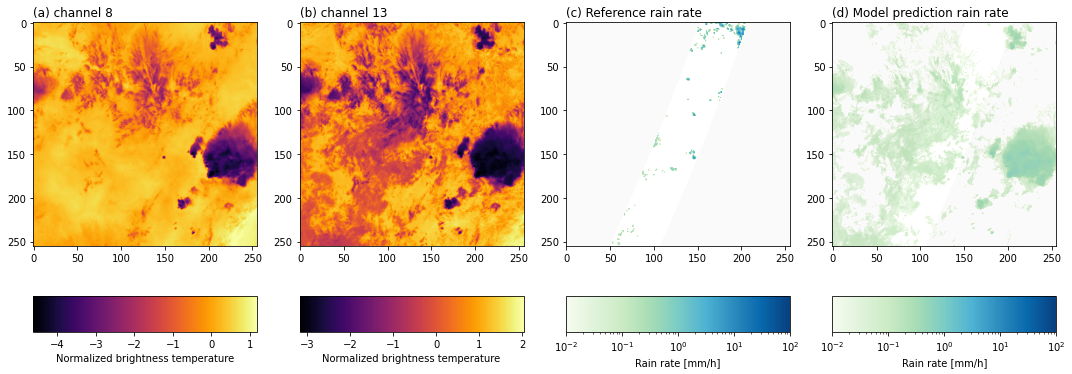

In [8]:
quantile_num=int(len(quantiles)/2)
print(quantiles[quantile_num])
ind = plotRandomSample(val_dataset, net=net, quantile_num=quantile_num, device=device)
print('index ', ind)

In [9]:
'''
tot_loss = 0
for batch_index, batch in enumerate(test_dataloader):

    X = batch['box']
    y = batch['label']

    output = net(X)
    
    output_masked = mask(output, y)
    
    batch_loss = criterion(output_masked, y)

    tot_loss += batch_loss.item()

print(tot_loss, tot_loss, 'average: ', tot_loss/(batch_index+1))

'''

"\ntot_loss = 0\nfor batch_index, batch in enumerate(test_dataloader):\n\n    X = batch['box']\n    y = batch['label']\n\n    output = net(X)\n    \n    output_masked = mask(output, y)\n    \n    batch_loss = criterion(output_masked, y)\n\n    tot_loss += batch_loss.item()\n\nprint(tot_loss, tot_loss, 'average: ', tot_loss/(batch_index+1))\n\n"